C:\Users\m.dhanasekar\AppData\Local\miniforge3\Lib\site-packages\scipy\stats\_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se



=== Descriptive Statistics ===
  Condition  N   Mean  Median     Q1    Q3   SEM
0       Pre  4  94.25    95.0  91.25  98.0  2.25
1      Post  4  94.25    95.0  91.25  98.0  2.25

=== Wilcoxon signed-rank (paired) ===
Statistic = 0.000, p = 1.0000 (ns)


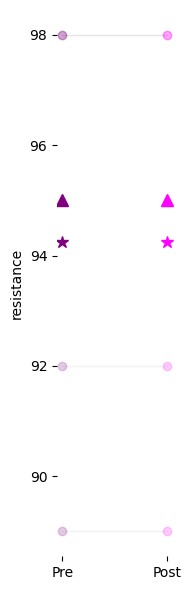


Plots have been generated and saved.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, mannwhitneyu

# ==========================================
# Load data
# ==========================================
csv_file_path = r'C:\Maha\DATA\patch_clamp\Kevin\input_resistance\input_resistance_voltage.csv'
df = pd.read_csv(csv_file_path)

# ==========================================
# Configuration
# ==========================================
parameter = 'resistance'
color_mapping = {'Pre': 'purple', 'Post': 'magenta'}

# ==========================================
# Compute descriptive statistics
# ==========================================
stats_summary = []

for condition in ['Pre', 'Post']:
    subset = df[df['Condition'] == condition][parameter].dropna()
    stats_summary.append({
        'Condition': condition,
        'N': subset.count(),
        'Mean': subset.mean(),
        'Median': subset.median(),
        'Q1': subset.quantile(0.25),
        'Q3': subset.quantile(0.75),
        'SEM': subset.std(ddof=1) / np.sqrt(subset.count())
    })

stats_df = pd.DataFrame(stats_summary)

# ==========================================
# Run statistical tests
# ==========================================
pre_values = df[df['Condition'] == 'Pre'][parameter].dropna().values
post_values = df[df['Condition'] == 'Post'][parameter].dropna().values

paired = len(pre_values) == len(post_values)

if paired:
    try:
        stat, p_value = wilcoxon(pre_values, post_values)
        test_used = "Wilcoxon signed-rank (paired)"
    except ValueError:
        stat, p_value = mannwhitneyu(pre_values, post_values, alternative='two-sided')
        test_used = "Mann–Whitney U (fallback)"
else:
    stat, p_value = mannwhitneyu(pre_values, post_values, alternative='two-sided')
    test_used = "Mann–Whitney U (unpaired)"

def p_to_stars(p):
    if p < 1e-4: return "****"
    elif p < 1e-3: return "***"
    elif p < 1e-2: return "**"
    elif p < 0.05: return "*"
    else: return "ns"

significance = p_to_stars(p_value)

# ==========================================
# Display stats
# ==========================================
print("\n=== Descriptive Statistics ===")
print(stats_df.round(3))

print(f"\n=== {test_used} ===")
print(f"Statistic = {stat:.3f}, p = {p_value:.4f} ({significance})")

# ==========================================
# Plot
# ==========================================
fig, ax = plt.subplots(figsize=(2, 6))

pre_subset = df[df['Condition'] == 'Pre'].sort_values(by=parameter)
post_subset = df[df['Condition'] == 'Post'].sort_values(by=parameter)

# Plot individual points
for condition, color in color_mapping.items():
    subset = df[df['Condition'] == condition]
    ax.plot([condition] * len(subset), subset[parameter], 'o', color=color, alpha=0.2)
    
    # Add mean and median markers
    mean_val = subset[parameter].mean()
    median_val = subset[parameter].median()
    ax.plot([condition], [mean_val], marker='*', color=color, markersize=9, linestyle='None', label=f'{condition} mean')
    ax.plot([condition], [median_val], marker='^', color=color, markersize=9, linestyle='None', label=f'{condition} median')

# Connect pairs if possible
if paired:
    for pre, post in zip(pre_subset[parameter], post_subset[parameter]):
        ax.plot(['Pre', 'Post'], [pre, post], color='black', alpha=0.05, linewidth=1)

ax.set_ylabel(parameter)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.tight_layout()

# Save
base_dir = os.path.dirname(csv_file_path)
svg_path = os.path.join(base_dir, f'{parameter}_prepost_plot.svg')
pdf_path = os.path.join(base_dir, f'{parameter}_prepost_plot.pdf')
fig.savefig(svg_path)
fig.savefig(pdf_path)

plt.show()

print("\nPlots have been generated and saved.")


In [1]:
import pyabf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
# Load the ABF file
file_path = r'C:\Maha\DATA\patch_clamp\Kevin\synaptic_connectivity\opsin\140524_F1_C1\CC\t3\24514033.abf'  # Replace with your file path
abf = pyabf.ABF(file_path)

# Select Channel 2 (index 1 since Python is 0-indexed) for square pulses
channel_index_pulse = 1
abf.setSweep(sweepNumber=0, channel=channel_index_pulse)

# Extract the time and voltage data for Channel 2
time_pulse = abf.sweepX  # Time in seconds
voltage_pulse = abf.sweepY  # Voltage in mV

# Identify the start of the square pulses (rising edges)
rising_edges_indices = np.where(np.diff(voltage_pulse) > 10)[0]  # Adjust threshold if necessary
rising_edges_times = time_pulse[rising_edges_indices]

print(f"Rising edges detected at {rising_edges_times} seconds.")

# Switch to the channel where the action potentials (bursts) are present, usually Channel 1 (index 0)
channel_index_burst = 0
abf.setSweep(sweepNumber=9, channel=channel_index_burst)

# Extract the time and voltage data for the action potential channel
time_burst = abf.sweepX  # Time in seconds
voltage_burst = abf.sweepY  # Voltage in mV


Rising edges detected at [] seconds.


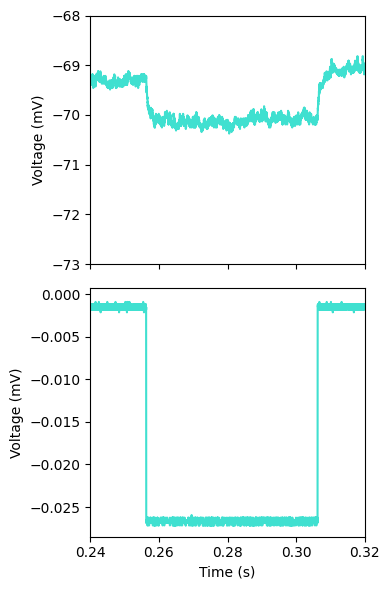

In [7]:
# Plotting
fig, axs = plt.subplots(2, 1, figsize=(4, 6), sharex=True)

axs[0].plot(time_burst, voltage_burst, label='Voltage Trace (Channel 1)', color='turquoise')
for rising_edge_time in rising_edges_times:
    axs[0].axvline(x=rising_edge_time, color='g', linestyle='--')
axs[0].set_xlim(6.5, 6.7)
axs[0].set_ylim(-73, -68)
#axs[0].set_title('Zoomed Voltage Trace with Peaks and Rising Edges (Channel 1)')
axs[0].set_ylabel('Voltage (mV)')

# Plot for Channel 2 (square pulses) - different zoom level
axs[1].plot(time_pulse, voltage_pulse, color='turquoise')
for rising_edge_time in rising_edges_times:
    axs[1].axvline(x=rising_edge_time, color='g', linestyle='--')
axs[1].set_xlim(0.24, 0.32)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Voltage (mV)')

plt.tight_layout()
plt.savefig(r'C:\Maha\DATA\patch_clamp\Kevin\input_resistance\post_new.svg')
plt.savefig(r'C:\Maha\DATA\patch_clamp\Kevin\input_resistance\post_new.pdf')
plt.show()